In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-mask-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
from fastai.vision.all import *  # Import all vision-related functions/classes
import os
import pandas as pd
import numpy as np


In [8]:
x  = "/content/data"
path = Path(x)
path.ls()

(#2) [Path('/content/data/without_mask'),Path('/content/data/with_mask')]

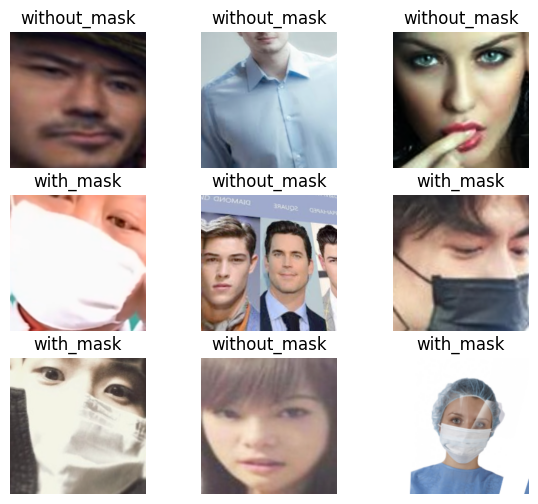

In [16]:
from fastai.vision.all import *  # Import all vision-related functions/classes
import os

# Set random seed
np.random.seed(40)

# Define your data block with normalization
data_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       get_y=parent_label,
                       item_tfms=Resize(224),
                       batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

# Create your data loaders
data_loaders = data_block.dataloaders(path, num_workers=4)

# Show a batch of images
# Show a batch of images
data_loaders.show_batch(figsize=(7, 6))



In [19]:

print(data_loaders.vocab)  # Print the classes
print(len(data_loaders.vocab))  # Get the number of classes


['with_mask', 'without_mask']
2


In [20]:
data_loaders

**We now use a pre-trained ResNet50 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network.**


# Why Transfer learning?

Because with transfer learning, you begin with an existing (trained) neural network used for image recognition — and then tweak it a bit (or more) here and there to train a model for your particular use case. And why do we do that? Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, we’re going to need at least a million images.


In our case, we have approximately 4000+ images in our training set — you have one guess to decide if that would have been enough if were to train a neural net from scratch.
We use the create_cnn() function for loading a pre-trained ResNet18 network, that was trained on around a million images from the ImageNet database.

In [28]:
learn = cnn_learner(data_loaders,
                    resnet50,
                    metrics=[accuracy],
                    model_dir=Path("/content"),
                    path=Path("/content"))


In [29]:
from pathlib import Path

# Define the folder path
folder_path = Path("/content")

# Check if the folder exists
if folder_path.exists():
    print("Folder exists.")
    # Print the contents of the folder
    print("Folder contents:")
    for item in folder_path.iterdir():
        print(item.name)
else:
    print("Folder does not exist.")


Folder exists.
Folder contents:
.config
face-mask-dataset.zip
data
kaggle.json
sample_data


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


SuggestedLRs(valley=0.001737800776027143)

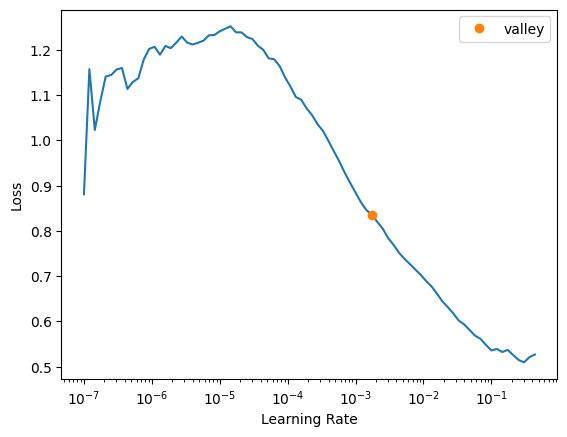

In [33]:
# Find optimal learning rate
learn.lr_find()




# 4.3 Train Model

In [34]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(4,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,0.260373,0.130569,0.976159,00:53
1,0.183420,0.048310,0.994702,00:53
2,0.062087,0.056117,0.994702,00:55
3,0.032960,0.041518,0.994040,00:57


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

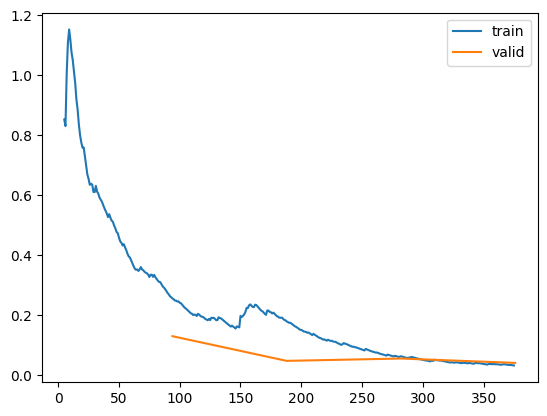

In [36]:
# Access the Recorder object from the learner
recorder = learn.recorder

# Plot the training loss
recorder.plot_loss()

5.1 Interpret the results

Model performance can be validated in different ways. One of the popular methods is using the confusion matrix. Diagonal values of the matrix indicate correct predictions for each class, whereas other cell values indicate a number of wrong predictions.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


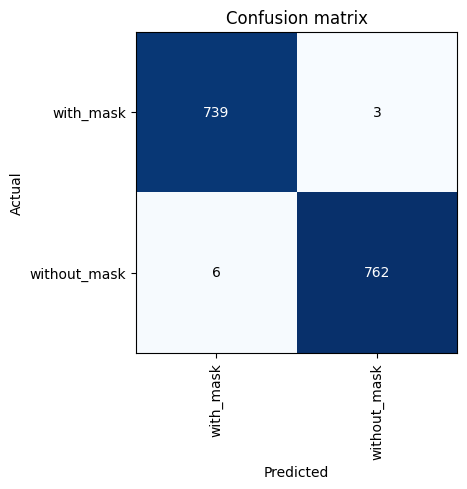

In [37]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

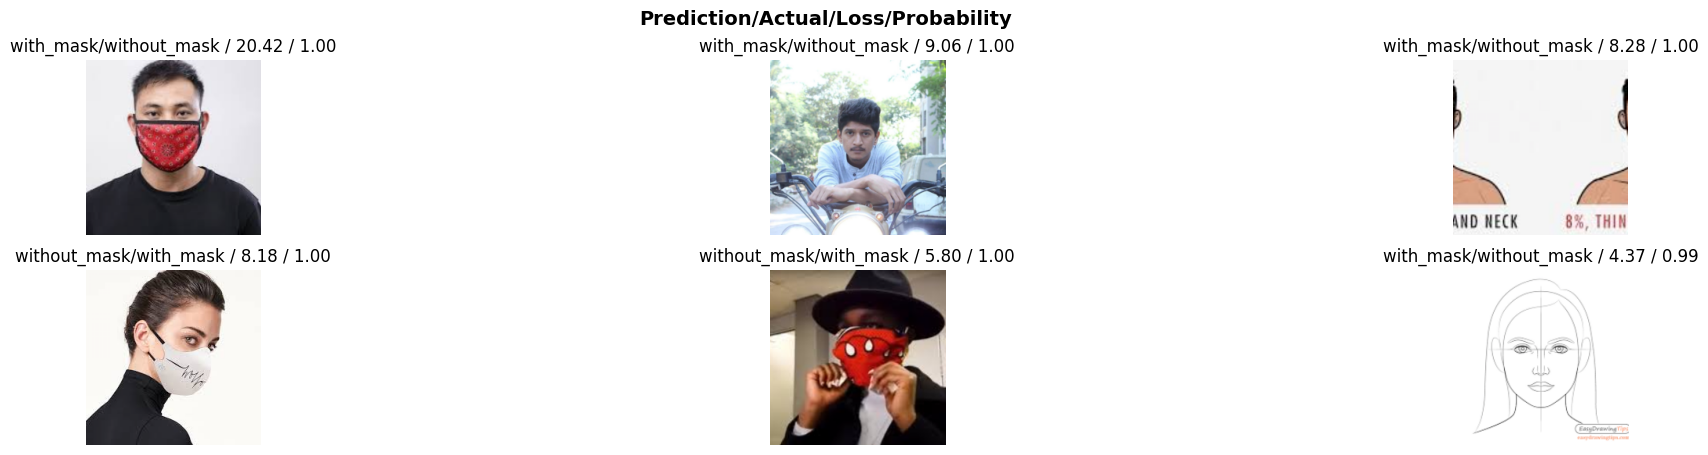

In [38]:
interp.plot_top_losses(6,figsize = (25,5))

In [46]:
from pathlib import Path
import shutil

# Define the export file path
export_file_path = Path("/content/export.pkl")

# Export the model
learn.export(export_file_path)

# Define the model directory
model_dir = "/content"

# Move the exported model file to the desired directory
exported_model_path = Path(model_dir) / "export.pkl"
shutil.move(export_file_path, exported_model_path)

# Print the path where the model is saved
print("Model saved at:", exported_model_path)


Model saved at: /content/export.pkl


# Take Your image and Model to get the **prediction**

In [47]:
from fastai.vision.all import *

# Define the path to the exported .pkl file
model_file_path = "/content/export.pkl"

# Load the exported model
learn = load_learner(model_file_path)

# Define the path to the image you want to make predictions on
image_path = "/content/anki_photo2.jpg"

# Load the image
image = PILImage.create(image_path)

# Make predictions
prediction, _, probabilities = learn.predict(image)

# Print the predicted label and probabilities
print("Predicted label:", prediction)
print("Probabilities:", probabilities)


Predicted label: without_mask
Probabilities: tensor([1.3356e-07, 1.0000e+00])


In [48]:
from fastai.vision.all import *

# Define the path to the exported .pkl file
model_file_path = "/content/export.pkl"

# Load the exported model
learn = load_learner(model_file_path)

# Define the path to the image you want to make predictions on
image_path = "/content/maskedimage.jpg"

# Load the image
image = PILImage.create(image_path)

# Make predictions
prediction, _, probabilities = learn.predict(image)

# Print the predicted label and probabilities
print("Predicted label:", prediction)
print("Probabilities:", probabilities)


Predicted label: with_mask
Probabilities: tensor([1.0000e+00, 1.0100e-09])
